In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

加载数据

In [2]:
spd_data = np.load("cleandata.npy", allow_pickle=True)
spd_data.shape

(471, 1494)

PCA 

In [3]:

n_components = 8
pca = PCA(n_components=n_components)

# 对SPD数据进行PCA分析，得到得分矩阵
scores = pca.fit_transform(spd_data)  # 1494x8的矩阵

scores.shape


(471, 8)

In [4]:
# 构建高斯滤波器集合
mu = np.array([415, 445, 480, 515, 555, 590, 630, 680])
sigma = np.array([11.0403, 12.7388, 15.2866, 16.5605, 16.5605, 16.9851, 21.2314, 22.0807])
wavelengths = np.arange(360, 831)
filters = np.zeros((8, len(wavelengths)))
for i in range(8):
    filters[i] = np.exp(-0.5 * ((wavelengths - mu[i]) / sigma[i])**2)

# 将得分矩阵与高斯滤波器集合相乘，得到M矩阵
M = np.dot(filters, scores)  # (8,471)的矩阵乘以(471,8)的矩阵得到8x8的矩阵


In [5]:
M.shape

(8, 8)

In [6]:
# 计算响应矩阵
response_matrix = np.dot(filters, spd_data)

# 计算响应矩阵的平均值
mean_response = np.mean(response_matrix, axis=1)
mean_response = mean_response.reshape(-1, 1) # 将平均响应向量变成一个列向量

print(mean_response)
print(mean_response.shape) #(8,1)



[[0.036534920539607614]
 [0.29821023297154964]
 [0.2535773618779846]
 [0.37819348604623915]
 [0.596526046603663]
 [0.7175100071781976]
 [0.7856590049375198]
 [0.38293180734937315]]
(8, 1)


In [7]:
response_matrix.shape

(8, 1494)

求伪逆矩阵

In [8]:
M_inv= np.linalg.inv(M)
M_inv.shape #(8,8)

(8, 8)

现在，我们已经有了$M_{-1} , r, r_{\mu}$, 下面计算$\hat{a_{i}}$

In [9]:
response_diff = response_matrix - mean_response
print(response_diff.shape)

a_hat = np.dot(M_inv, response_diff)
print(a_hat.shape)


(8, 1494)
(8, 1494)


光谱重建


In [28]:
mean_spd = np.mean(spd_data, axis=1) #(471,1)
re_spectrum_1 = np.dot(scores, a_hat[:,1]) 
spectrum_1 = spd_data[:,1]



MAE
RMSE
RRMSE

In [32]:
MAE = np.mean(np.absolute(re_spectrum_1-spectrum_1))
print("MAE: ", MAE)

#rmse
RMSE = np.sqrt(np.mean(np.square(re_spectrum_1 - spectrum_1)))
print("RMSE: ", RMSE)

#rrmse
RRMSE = RMSE / np.mean(spectrum_1)
print("RRMSE: ", RRMSE)

MAE:  0.007531972866201216
RMSE:  0.009661222189135423
RRMSE:  1.2918805911209463


$GFC = \frac{|\sum_{i=1}^{n}(S_i\bar{S})|}{\sqrt{\sum_{i=1}^{n}(S_i)^2}\sqrt{\sum_{i=1}^{n}(\bar{s})^2}}$

In [35]:
def compute_GFC(s, s_hat):
    num = abs(np.sum(s * s_hat))
    denom_s = np.sqrt(np.sum(s ** 2) + 1e-9)
    denom_s_hat = np.sqrt(np.sum(s_hat ** 2) + 1e-9)
    return num / (denom_s * denom_s_hat)

GFC = compute_GFC(spectrum_1, re_spectrum_1)
print(GFC)

0.6252227043317207


光谱重建2

In [36]:
#mean_spd = np.mean(spd_data, axis=1) #(471,1)
re_spectrum_2 = np.dot(scores, a_hat[:,2]) + mean_spd 
print(re_spectrum_2.shape)
spectrum_2 = spd_data[:,2]


(471,)


In [37]:
def compute_MAE(s, s_re):
    return np.mean(np.absolute(s - s_re))

def compute_RMSE(s, s_re):
    return np.sqrt(np.mean(np.square(s- s_re)))

def compute_RRMSE(s, s_re):
    return compute_RMSE(s, s_re) / np.mean(s_re)

def compute_GFC(s, s_hat):
    num = abs(np.sum(s * s_hat))
    denom_s = np.sqrt(np.sum(s ** 2) + 1e-9)
    denom_s_hat = np.sqrt(np.sum(s_hat ** 2) + 1e-9)
    return num / (denom_s * denom_s_hat)




MAE2 = compute_MAE(spectrum_2, re_spectrum_2)
RMSE2 = compute_RMSE(spectrum_2, re_spectrum_2)
RRMSE2 = compute_RRMSE(spectrum_2, re_spectrum_2)
GFC2 = compute_GFC(spectrum_2, re_spectrum_2)

print("MAE: ", MAE2)
print("RMSE: ", RMSE2)
print("RRMES: ", RRMSE2)
print("GFC: ", GFC2)


MAE:  0.0012197726109517493
RMSE:  0.0016693121300392487
RRMES:  0.2437061926937877
GFC:  0.9903899396167556


In [ ]:
# 创建一个包含三个子图的图像
fig, axs = plt.subplots(3, 1)

# 绘制真实光谱图
axs[0].plot(wavelengths, mean_spd, label='True Spectrum')
axs[0].set_xlabel('Wavelength (nm)')
axs[0].set_ylabel('Intensity')
axs[0].set_title('True Spectrum vs Reconstructed Spectrum')
axs[0].legend()

# 绘制重建光谱图
axs[1].plot(wavelengths, mean_respectrum, label='Reconstructed Spectrum')
axs[1].set_xlabel('Wavelength (nm)')
axs[1].set_ylabel('Intensity')
axs[1].legend()

# 绘制重建光谱和真实光谱叠加的图
axs[2].plot(wavelengths, mean_spd, label='True Spectrum')
axs[2].plot(wavelengths, mean_respectrum, label='Reconstructed Spectrum')
axs[2].set_xlabel('Wavelength (nm)')
axs[2].set_ylabel('Intensity')
axs[2].legend()

plt.tight_layout()
plt.show()

对整个光谱进行评估

In [43]:
x = mean_spd[:, np.newaxis]
print(x.shape)
print(mean_spd.shape)

(471, 1)
(471,)


In [44]:
reconstructed_spectrum = np.dot(scores, a_hat) + mean_spd[:, np.newaxis]
reconstructed_spectrum.shape

(471, 1494)

In [46]:
MAE = compute_MAE(spd_data, reconstructed_spectrum)
RMSE = compute_RMSE(spd_data, reconstructed_spectrum)
RRMSE = compute_RRMSE(spd_data, reconstructed_spectrum)
GFC = compute_GFC(spd_data, reconstructed_spectrum)

print("MAE: ", MAE)
print("RMSE: ", RMSE)
print("RRMES: ", RRMSE)
print("GFC: ", GFC)

MAE:  0.0009265913730848997
RMSE:  0.0018211058688071243
RRMES:  0.2658668620402661
GFC:  0.9829788545240704


效果不好，我打算用平均值展示

In [47]:
mean_respectrum = np.mean(reconstructed_spectrum, axis=1) #(471,1)

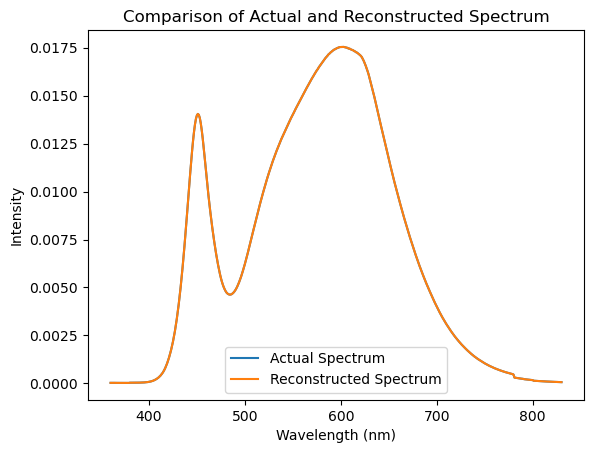

In [50]:
# 波长范围
wavelengths = range(360, 831)

# 绘制实际光谱
plt.plot(wavelengths, mean_spd, label='Actual Spectrum')

# 绘制重建光谱
plt.plot(wavelengths, mean_respectrum, label='Reconstructed Spectrum')

# 添加图例
plt.legend()

# 添加标题和标签
plt.title('Comparison of Actual and Reconstructed Spectrum')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')

# 显示图形
plt.show()

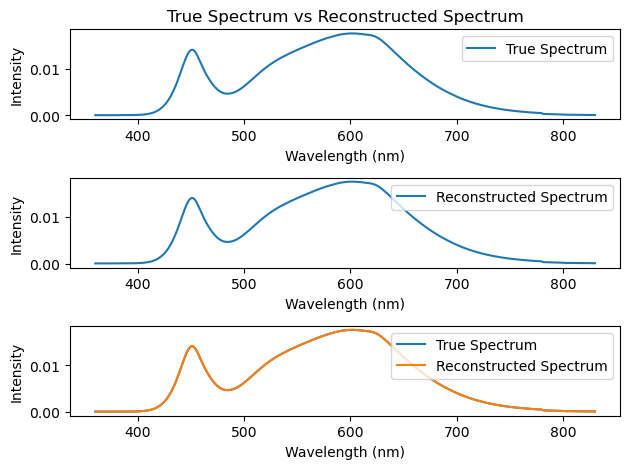

In [52]:

# 创建一个包含三个子图的图像
fig, axs = plt.subplots(3, 1)

# 绘制真实光谱图
axs[0].plot(wavelengths, mean_spd, label='True Spectrum')
axs[0].set_xlabel('Wavelength (nm)')
axs[0].set_ylabel('Intensity')
axs[0].set_title('True Spectrum vs Reconstructed Spectrum')
axs[0].legend()

# 绘制重建光谱图
axs[1].plot(wavelengths, mean_respectrum, label='Reconstructed Spectrum')
axs[1].set_xlabel('Wavelength (nm)')
axs[1].set_ylabel('Intensity')
axs[1].legend()

# 绘制重建光谱和真实光谱叠加的图
axs[2].plot(wavelengths, mean_spd, label='True Spectrum')
axs[2].plot(wavelengths, mean_respectrum, label='Reconstructed Spectrum')
axs[2].set_xlabel('Wavelength (nm)')
axs[2].set_ylabel('Intensity')
axs[2].legend()

plt.tight_layout()
plt.show()
